# Calculate limb-darkening coefficients

In this tutorial we walk through various options for calculating stellar limb-darkening coefficients. Let us start by importing the required packages.

In [1]:
import os
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from exotic_ld import StellarLimbDarkening


First, instantiate the StellarLimbDarkening class. Here you must specify the stellar parameters and the stellar models. We have also set verbose=2 to get some extra information about what is going on under the hood, but you can set this to 1 or 0 to get fewer or no outputs to your console.

In [2]:
sld = StellarLimbDarkening(M_H=0.01, Teff=5512, logg=4.47, 
                           ld_model="mps1", 
                           ld_data_path="exotic_ld_data", 
                           interpolate_type="nearest",
                           verbose=2)

Input stellar parameters are M_H=0.01, Teff=5512, logg=4.47.
Loading stellar model from mps1 grid.
Using interpolation type = nearest.
Matched nearest with M_H=0.0, Teff=5500.0, logg=4.5.


Downloaded exotic_ld_data/mps1/MH0.0/teff5500/logg4.5/mps1_spectra.dat.
Stellar model loaded.


During instantiation stellar models are loaded based on your input stellar parameters. By default, the nearest matching model is located in the specified stellar grid. However, you may set interpolate_type="trilinear", and the stellar models will be linearly interpolated in each of the three parameter dimensions.

You can inspect the loaded stellar model using the following attributes.

(1221,)
(24,)
(1221, 24)


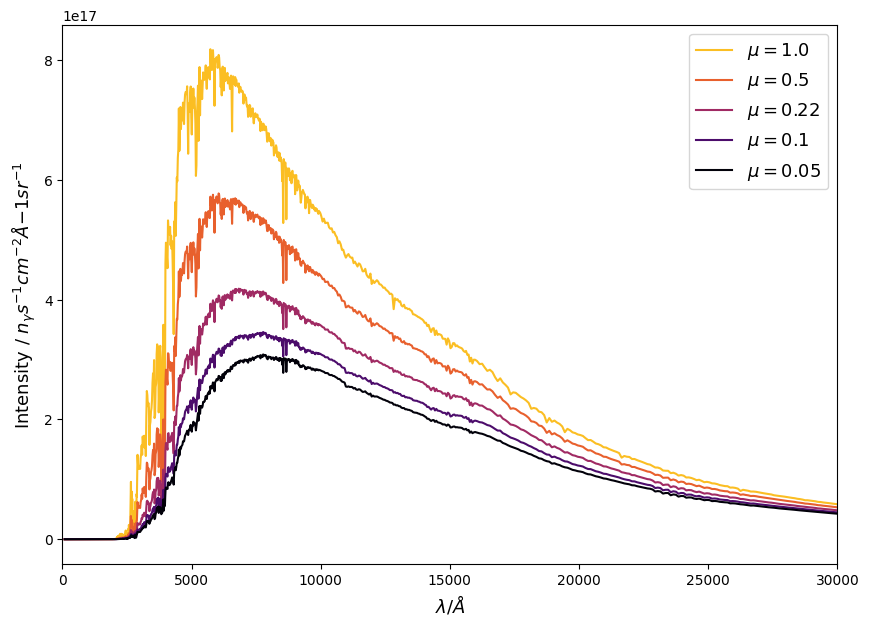

In [3]:
print(sld.stellar_wavelengths.shape)
print(sld.mus.shape)
print(sld.stellar_intensities.shape)

plt.figure(figsize=(10, 7))
for mu_idx in np.arange(0, sld.mus.shape[0], 5):
    plt.plot(sld.stellar_wavelengths, sld.stellar_intensities[:, mu_idx], 
             color=cm.inferno(0.85 - mu_idx/sld.mus.shape[0]), label="$\mu={}$".format(sld.mus[mu_idx]))
plt.xlabel("$\lambda / \AA$", fontsize=13)
plt.ylabel("Intensity / $n_{\gamma} s^{-1} cm^{-2} \AA{-1} sr^{-1}$", fontsize=13)
plt.xlim(0, 3e4)
plt.legend(loc="upper right", fontsize=13)
plt.show()

With the stellar model loaded, you can compute the stellar limb-darkening coefficients for the limb-darkening law of your choice. You simply have to specify the instrument mode and the wavelength range you require. You can also limit the range of $\mu$ values that are included in the fit. The choice of limb-darkening law will depend on your application, so if you are in any doubt, [Sing (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...510A..21S/abstract) or [Espinoza & Jordán (2016)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.457.3573E/abstract) are good places to start.

In [4]:
us = sld.compute_4_parameter_non_linear_ld_coeffs(wavelength_range=[20000., 30000.], 
                                                  mode="JWST_NIRSpec_Prism", 
                                                  mu_min=0.1)

Downloaded exotic_ld_data/Sensitivity_files/JWST_NIRSpec_Prism_throughput.csv.
Loading instrument mode=JWST_NIRSpec_Prism with wavelength range 6000.0-53000.0 A.
Integrating I(mu) for wavelength limits of 20000.0-30000.0 A.
Integral done for I(mu).
Fitting limb-darkening law to 16 I(mu) data points where 0.1 <= mu <= 1, with the Levenberg-Marquardt algorithm.
Fit done, resulting coefficients are [ 0.49195979  0.13317744 -0.32752393  0.13150929].


Finally, you can inspect the fitted limb-darkening coefficients. To do this, you can find the integrated intensity profile in the attribute sld.I_mu, and the limb-darkening laws are all defined in the submodule, exotic_ld.ld_laws.

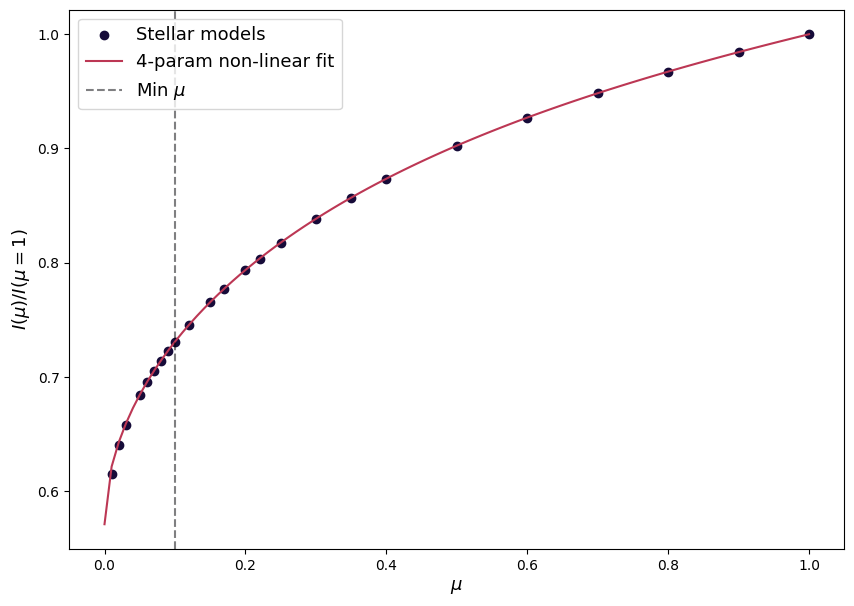

In [5]:
from exotic_ld.ld_laws import nonlinear_4param_ld_law


plt.figure(figsize=(10, 7))
plt.scatter(sld.mus, sld.I_mu, color=cm.inferno(0.1), label="Stellar models")
check_mus = np.linspace(0., 1., 100)
plt.plot(check_mus, nonlinear_4param_ld_law(check_mus, *us), 
         color=cm.inferno(0.5), label="4-param non-linear fit")
plt.axvline(0.1, ls="--", color=cm.inferno(0.), alpha=0.5, label="Min $\mu$")
plt.ylabel("$I(\mu) / I(\mu=1)$", fontsize=13)
plt.xlabel("$\mu$", fontsize=13)
plt.legend(loc="upper left", fontsize=13)
plt.show()

The returned tuple of limb-darkening coefficients, us, is now ready to be used in your analysis.